<a href="https://colab.research.google.com/github/emattia/Geneformer/blob/main/Economic_data_APIs_Series_BEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

## Resources
- [US Census Data user guide](https://www.census.gov/data/developers/guidance/api-user-guide.Example_API_Queries.html)
- [Bureau of Economic Analysis (BEA) Data Application Programming Interface (API)
](https://apps.bea.gov/api/_pdf/bea_web_service_api_user_guide.pdf)

## Dependencies

In [ ]:
%env BEA_API_KEY=<>

In [ ]:
import os
import requests
import pandas as pd
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt

custom_params = {
  "axes.spines.right": False,
  "axes.spines.top": False
}

sns.set_theme(
    context='notebook',
    style='dark',
    palette='deep',
    font='sans-serif',
    font_scale=1,
    color_codes=True,
    rc=custom_params
)

## Utility functions

In [4]:
BEA_API_BASE_URL='https://apps.bea.gov/api/data'
BEA_VALID_METHODS = {

    ### Metadata API methods ###
    'GETDATASETLIST': {
        "description": "Retrieves a list of the current datasets.",
        "required_params": None
    },

    'getparameterlist': {
        "description": "Retrieves a list of the current parameters for a dataset.",
        "required_params": ['datasetname']
    },

    'GetParameterValues': {
        "description": "Retrives a set of valid values for a dataset's parameter.",
        "required_params": ['datasetname', 'ParameterName']
    },

    'GetData': {
        "description": "",
        "required_params": ["datasetname"]
    }

}

def bea_get_valid_methods():
    return BEA_VALID_METHODS

def bea_query(
    method,
    parameters=None,
    result_format='JSON',
    display_query=False
):
  """
  -----------
  Description
  -----------
  Run a query against the BEA API.

  ---------
  Required Arguments
  ---------
  method (str): A method in BEA_VALID_METHODS.

  ---------
  Optional Arguments
  ---------
  parameters (dict[str, str]): A map of parameter unique to the method.
  result_format (str): A value in [JSON].
  display_query (bool): Whether to print the query URL for debugging.

  -------
  Returns
  -------
  dict: The JSON response from the BEA API.
  """

  if method not in BEA_VALID_METHODS.keys():
    raise ValueError(f'Invalid method: {method}')
  if result_format not in ['JSON']:
    raise ValueError(f'Invalid result_format: {result_format}')

  required_params = BEA_VALID_METHODS[method]['required_params']
  if required_params is not None:
    for param in required_params:
      if param not in parameters.keys():
        raise ValueError(f'Missing required parameter: {param}')

  query_url = f"{BEA_API_BASE_URL}?UserID={os.environ['BEA_API_KEY']}&method={method}"
  if parameters is not None:
    for param_name, param_value in parameters.items():
      query_url = f"{query_url}&{param_name}={param_value}"
  if result_format is not None:
    query_url = f"{query_url}&ResultFormat={result_format}"
  if display_query:
    print(query_url)

  response = requests.get(query_url)
  response.raise_for_status()
  if response.status_code == 429:
    raise Exception('Too many requests. Try again in one hour.')
  try:
    return response.json()['BEAAPI']['Results']
  except KeyError:
    raise Exception(response.json())

def bea_get_dataset_list():
  results = bea_query(method='GETDATASETLIST')
  return results['Dataset']

def bea_get_parameter_list(dataset_name):
  results = bea_query(
    method='getparameterlist',
    parameters={
      'datasetname': dataset_name
    }
  )
  return results['Parameter']

def bea_get_parameter_values(
    dataset_name,
    parameter_name
):
  results = bea_query(
    method='GetParameterValues',
    parameters={
      'datasetname': dataset_name,
      'ParameterName': parameter_name
    }
  )
  return results


def bea_get_data(dataset_name, parameters):

  parameter_list = bea_get_parameter_list(dataset_name)
  parameter_names = [p['ParameterName'] for p in parameter_list]

  for param_name, param_val in parameters.items():
    if param_name not in parameter_names:
      raise ValueError(f'Invalid parameter {param_name}, for dataset {dataset_name}. Valid parameters are: {parameter_names}')

  for p in parameter_list:
    if p['ParameterIsRequiredFlag'] == '1': # or p['ParameterName'] == 'TableName': # bug in API?
      if p['ParameterName'] not in parameters.keys():
        raise ValueError(f'Missing required parameter: {p["ParameterName"]}')

  results = bea_query(
    method='GetData',
    parameters={
      'datasetname': dataset_name,
      **parameters
    },
    display_query=True
  )
  return results

def bea_pack_results(res, print_summary=False):
  table_name = res['Statistic']
  table_production_time = res['UTCProductionTime']
  table_notes = [n['NoteText'] for n in res['Notes']]
  table_data = res['Data']
  if print_summary:
    print(f"\nTable {table_name} produced at: {table_production_time}")
    print('\n' + '\n'.join(table_notes))

  return pd.DataFrame(table_data)

def bea_get_tablename_from_tableid(id):
  res = bea_get_parameter_values('NIPA', 'TableName')
  for table_info in res['ParamValue']:
    if id in table_info['Description']:
      return table_info['TableName']
  return None

In [5]:
pprint(bea_get_dataset_list())

[{'DatasetDescription': 'Standard NIPA tables', 'DatasetName': 'NIPA'},
 {'DatasetDescription': 'Standard NI underlying detail tables',
  'DatasetName': 'NIUnderlyingDetail'},
 {'DatasetDescription': 'Multinational Enterprises', 'DatasetName': 'MNE'},
 {'DatasetDescription': 'Standard Fixed Assets tables',
  'DatasetName': 'FixedAssets'},
 {'DatasetDescription': 'International Transactions Accounts',
  'DatasetName': 'ITA'},
 {'DatasetDescription': 'International Investment Position',
  'DatasetName': 'IIP'},
 {'DatasetDescription': 'Input-Output Data', 'DatasetName': 'InputOutput'},
 {'DatasetDescription': 'International Services Trade',
  'DatasetName': 'IntlServTrade'},
 {'DatasetDescription': 'International Services Supplied Through Affiliates',
  'DatasetName': 'IntlServSTA'},
 {'DatasetDescription': 'GDP by Industry', 'DatasetName': 'GDPbyIndustry'},
 {'DatasetDescription': 'Regional data sets', 'DatasetName': 'Regional'},
 {'DatasetDescription': 'Underlying GDP by Industry',
  '

## NIPA

The DataSetName is NIPA. This dataset contains data from the National Income and Product Accounts which include measures of the value and composition of U.S.production and the incomes generated in producing it. NIPA data is provided on a table basis; individual tables contain between fewer than 10 to more
than 200 distinct data series.

In [5]:
pprint(bea_get_parameter_list('NIPA'))

[{'AllValue': '',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': '',
  'ParameterDescription': 'A - Annual, Q-Quarterly, M-Monthly',
  'ParameterIsRequiredFlag': '1',
  'ParameterName': 'Frequency'},
 {'AllValue': '',
  'MultipleAcceptedFlag': '0',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': 'N',
  'ParameterDescription': 'A flag indicating that million-dollar data should '
                          'be returned.',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'ShowMillions'},
 {'AllValue': '',
  'MultipleAcceptedFlag': '0',
  'ParameterDataType': 'integer',
  'ParameterDescription': 'The standard NIPA table identifier',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'TableID'},
 {'AllValue': '',
  'MultipleAcceptedFlag': '0',
  'ParameterDataType': 'string',
  'ParameterDescription': 'The new NIPA table identifier',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'TableName'},
 {'AllValue': 'X',
  'MultipleA

### Utility functions

In [6]:
def bea_get_nipa_table_names(keywords=[]):

  res = bea_get_parameter_values('NIPA', 'TableName')

  keyword_related_nipa_table_names = {}
  for table_info in res['ParamValue']:
    for keyword in keywords:
      if keyword.lower() in table_info['Description'].lower():
        if keyword in keyword_related_nipa_table_names.keys():
          keyword_related_nipa_table_names[keyword].append(table_info['TableName'])
        else:
          keyword_related_nipa_table_names[keyword] = [table_info['TableName']]
        break
  return keyword_related_nipa_table_names

In [7]:
keyword_list = ['Gross Domestic Product']

gdpish_tables = bea_get_nipa_table_names(keyword_list)
total_found = 0
for k,v in gdpish_tables.items():
  total_found += len(v)
print(f"Found {total_found} tables.")
pprint(gdpish_tables['Gross Domestic Product'])

Found 43 tables.
['T10101',
 'T10102',
 'T10103',
 'T10104',
 'T10105',
 'T10106',
 'T10107',
 'T10108',
 'T10109',
 'T10110',
 'T10111',
 'T10201',
 'T10202',
 'T10203',
 'T10204',
 'T10205',
 'T10206',
 'T10401',
 'T10403',
 'T10404',
 'T10405',
 'T10406',
 'T10501',
 'T10502',
 'T10503',
 'T10504',
 'T10505',
 'T10506',
 'T10701',
 'T10703',
 'T10704',
 'T10705',
 'T10706',
 'T10803',
 'T10806',
 'T11701',
 'T11705',
 'T11706',
 'T80103',
 'T80104',
 'T80105',
 'T80106',
 'T80111']


### GDP

GDP datasets need a frequency of `Q` or `A`.

In [8]:
# for table_name in gdpish_tables['Gross Domestic Product']:
#   try:
#     res = bea_get_data('NIPA', {'Frequency': 'Q', 'Year': 'X', 'TableName': table_name})
#     break
#   except:
#     print(f'FAIL {table_name}')
#     continue

res = bea_get_data('NIPA', {
    'Frequency': 'Q',
    'Year': 'X',
    'TableName': bea_get_tablename_from_tableid('Table 1.1.5. Gross Domestic Product')
})

https://apps.bea.gov/api/data?UserID=85F57220-D987-4300-BEC9-B399CFF68EB0&method=GetData&datasetname=NIPA&Frequency=Q&Year=X&TableName=T10105&ResultFormat=JSON


In [9]:
gdp_df = bea_pack_results(res, print_summary=True)


Table NIPA Table produced at: 2025-04-21T01:48:52.253

Table 1.1.5. Gross Domestic Product [Billions of dollars] - LastRevised: March 27, 2025


In [10]:
gdp_df['Datetime'] = pd.PeriodIndex(gdp_df['TimePeriod'], freq='Q').to_timestamp()
gdp_df['DataNumeric'] = gdp_df['DataValue'].apply(lambda x: float(x.replace(',', '')))
gdp_df['UNIT_MULT_Numeric'] = gdp_df['UNIT_MULT'].apply(lambda x: int(x))
gdp_df['DataScaled'] = gdp_df['DataNumeric'] * 10**gdp_df['UNIT_MULT_Numeric']
gdp_df['DataScaled (Trillion)'] = gdp_df['DataScaled'] / 10**12

#### GDP over time

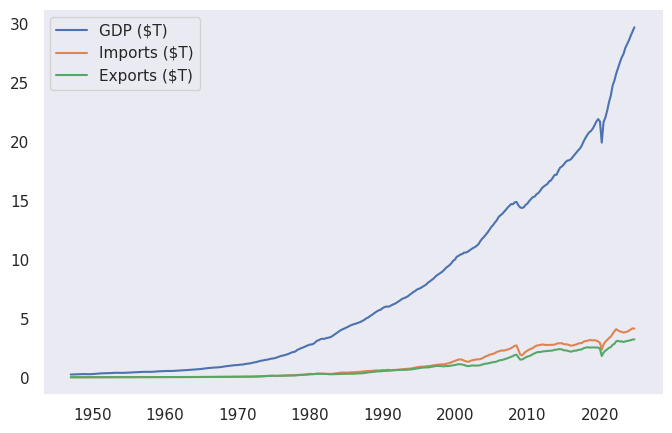

In [20]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

gdp_filtered = gdp_df[gdp_df['LineDescription'] == 'Gross domestic product']
ax.plot(
    gdp_filtered['Datetime'],
    gdp_filtered['DataScaled (Trillion)'],
    label='GDP ($T)'
)

imports_filtered = gdp_df[gdp_df['LineDescription'] == 'Imports']
ax.plot(
    imports_filtered['Datetime'],
    imports_filtered['DataScaled (Trillion)'],
    label='Imports ($T)'
)

exports_filtered = gdp_df[gdp_df['LineDescription'] == 'Exports']
ax.plot(
    exports_filtered['Datetime'],
    exports_filtered['DataScaled (Trillion)'],
    label='Exports ($T)'
)

# services_filtered = gdp_df[gdp_df['LineDescription'] == 'Services']
# ax.plot(
#     services_filtered['Datetime'],
#     services_filtered['DataScaled (Trillion)'],
#     label='Services ($T)'
# )

plt.legend()
plt.show()

#### Services breakdown

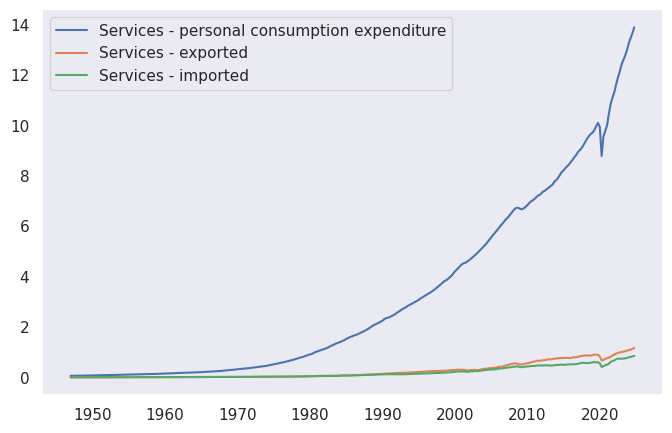

In [34]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

line_no_to_name = {
    '6': 'Services - personal consumption expenditure',
    '18': 'Services - exported',
    '21': 'Services - imported'
}

services = gdp_df[gdp_df['LineDescription'] == 'Services']
line_numbers = services['LineNumber'].unique()
for line_number in line_numbers:
  services_filtered = services[services['LineNumber'] == line_number]
  ax.plot(
    services_filtered['Datetime'],
    services_filtered['DataScaled (Trillion)'],
    label=line_no_to_name[line_number]
  )

plt.legend()
plt.show()

### Exports vs. Imports

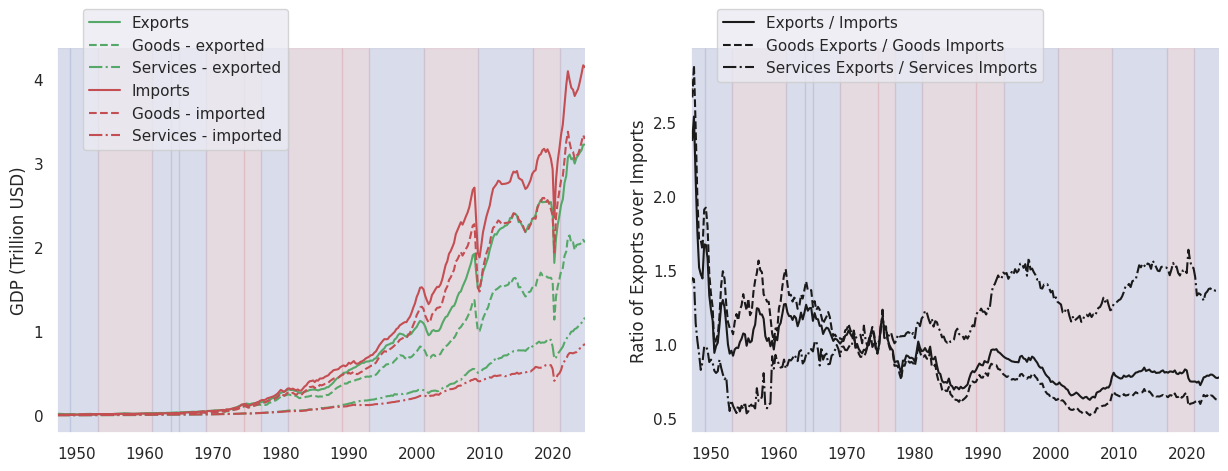

In [73]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

date_cut = gdp_df['Datetime'].min()
most_recent = gdp_df['Datetime'].max()

president_terms = [
    {
        'start': '1933-03-04',  # Franklin D. Roosevelt (prior terms)
        'end': '1941-01-19',
        'color': 'b',
        'name': 'Roosevelt'
    },
    {
        'start': '1941-01-20',  # Franklin D. Roosevelt (wartime term)
        'end': '1945-04-11',   # Date of FDR's death
        'color': 'b',
        'name': 'Roosevelt'
    },
    {
        'start': '1945-04-12',  # Harry S. Truman (following FDR's death)
        'end': '1949-01-19',
        'color': 'b',
        'name': 'Truman'
    },
    {
        'start': '1949-01-20',  # Harry S. Truman (elected term)
        'end': '1953-01-19',
        'color': 'b',
        'name': 'Truman'
    },
    {
        'start': '1953-01-20',  # Dwight D. Eisenhower
        'end': '1961-01-19',
        'color': 'r',
        'name': 'Eisenhower'
    },
    {
        'start': '1961-01-20',  # John F. Kennedy
        'end': '1963-11-21',   # Day before JFK's assassination
        'color': 'b',
        'name': 'Kennedy'
    },
    {
        'start': '1963-11-22',  # Lyndon B. Johnson (following JFK's assassination)
        'end': '1965-01-19',
        'color': 'b',
        'name': 'Johnson'
    },
    {
        'start': '1965-01-20',  # Lyndon B. Johnson (elected term)
        'end': '1969-01-19',
        'color': 'b',
        'name': 'Johnson'
    },
    {
        'start': '1969-01-20',  # Richard Nixon
        'end': '1974-08-08',   # Day before Nixon's resignation
        'color': 'r',
        'name': 'Nixon'
    },
    {
        'start': '1974-08-09',  # Gerald Ford
        'end': '1977-01-19',
        'color': 'r',
        'name': 'Ford'
    },
    {
        'start': '1977-01-20',  # Jimmy Carter
        'end': '1981-01-19',
        'color': 'b',
        'name': 'Carter'
    },
    {
        'start': '1981-01-20',  # Ronald Reagan
        'end': '1989-01-19',
        'color': 'r',
        'name': 'Reagan'
    },
    {
        'start': '1989-01-20',  # George H.W. Bush
        'end': '1993-01-19',
        'color': 'r',
        'name': 'Bush'
    },
    {
        'start': '1993-01-20',  # Bill Clinton
        'end': '2001-01-19',
        'color': 'b',
        'name': 'Clinton'
    },
    {
        'start': '2001-01-20',  # George W. Bush
        'end': '2009-01-19',
        'color': 'r',
        'name': 'W. Bush'
    },
    {
        'start': '2009-01-20',  # Barack Obama
        'end': '2017-01-19',
        'color': 'b',
        'name': 'Obama'
    },
    {
        'start': '2017-01-20',  # Donald Trump (first term)
        'end': '2021-01-19',
        'color': 'r',
        'name': 'Trump'
    },
    {
        'start': '2021-01-20',  # Joe Biden
        'end': '2025-01-19',
        'color': 'b',
        'name': 'Biden'
    },
    {
        'start': '2025-01-20',  # Donald Trump (second term)
        'end': '2029-01-19',
        'color': 'r',
        'name': 'Trump'
    }
]

if pd.to_datetime(president_terms[0]['start']) > date_cut:
  raise ValueError(f'Extend president terms list to include date before {date_cut}')

data_filtered = gdp_df[gdp_df['Datetime'] >= date_cut]

line_no_to_name = {
    '16': ('Exports', 'g', '-'),
    '17': ('Goods - exported', 'g', '--'),
    '18': ('Services - exported', 'g', '-.'),
    '19': ('Imports', 'r', '-'),
    '20': ('Goods - imported', 'r', '--'),
    '21': ('Services - imported', 'r', '-.')
}

for line_number in line_no_to_name.keys():
  line_filtered = data_filtered[data_filtered['LineNumber'] == line_number]
  ax[0].plot(
    line_filtered['Datetime'],
    line_filtered['DataScaled (Trillion)'],
    label=line_no_to_name[line_number][0],
    color=line_no_to_name[line_number][1],
    linestyle=line_no_to_name[line_number][2]
  )

exports_over_imports_ratio = data_filtered[data_filtered['LineNumber'] == '16']['DataScaled (Trillion)'].values / data_filtered[data_filtered['LineNumber'] == '19']['DataScaled (Trillion)'].values
goods_exports_over_goods_imports_ratio = data_filtered[data_filtered['LineNumber'] == '17']['DataScaled (Trillion)'].values / data_filtered[data_filtered['LineNumber'] == '20']['DataScaled (Trillion)'].values
services_exports_over_services_imports_ratio = data_filtered[data_filtered['LineNumber'] == '18']['DataScaled (Trillion)'].values / data_filtered[data_filtered['LineNumber'] == '21']['DataScaled (Trillion)'].values

ax[1].plot(
    data_filtered[data_filtered['LineNumber'] == '16']['Datetime'],
    exports_over_imports_ratio,
    label='Exports / Imports',
    color='k',
    linestyle='-'
)
ax[1].plot(
    data_filtered[data_filtered['LineNumber'] == '17']['Datetime'],
    goods_exports_over_goods_imports_ratio,
    label='Goods Exports / Goods Imports',
    color='k',
    linestyle='--'
)
ax[1].plot(
    data_filtered[data_filtered['LineNumber'] == '18']['Datetime'],
    services_exports_over_services_imports_ratio,
    label='Services Exports / Services Imports',
    color='k',
    linestyle='-.'
)

for term in president_terms:
  ax[0].axvspan(term['start'], term['end'], color=term['color'], alpha=0.1)
  ax[1].axvspan(term['start'], term['end'], color=term['color'], alpha=0.1)

ax[0].legend(
    bbox_to_anchor=(.05, 1.1),
    loc='upper left',
    borderaxespad=0.
)
ax[1].legend(
    bbox_to_anchor=(.05, 1.1),
    loc='upper left',
    borderaxespad=0.
)
ax[0].set_xlim(date_cut, most_recent)
ax[1].set_xlim(date_cut, most_recent)
ax[0].set_ylabel('GDP (Trillion USD)')
ax[1].set_ylabel('Ratio of Exports over Imports')
plt.show()

#### National Income

In [1]:
res = bea_get_data('NIPA', {
    'Frequency': 'Q',
    'Year': 'X',
    'TableName': bea_get_tablename_from_tableid('Table 6.1D. National Income Without Capital Consumption Adjustment by Industry')
})

NameError: name 'bea_get_data' is not defined

In [ ]:
gdp_df = bea_pack_results(res, print_summary=True)
gdp_df['Datetime'] = pd.PeriodIndex(gdp_df['TimePeriod'], freq='Q').to_timestamp()
gdp_df['DataNumeric'] = gdp_df['DataValue'].apply(lambda x: float(x.replace(',', '')))
gdp_df['UNIT_MULT_Numeric'] = gdp_df['UNIT_MULT'].apply(lambda x: int(x))
gdp_df['DataScaled'] = gdp_df['DataNumeric'] * 10**gdp_df['UNIT_MULT_Numeric']
gdp_df['DataScaled (Trillion)'] = gdp_df['DataScaled'] / 10**12

In [ ]:
gdp_df

### Wages

In [53]:
keyword = 'wages'

keyword_related_nipa_table_names = []
for table_info in res['ParamValue']:
  if keyword in table_info['Description'].lower():
    keyword_related_nipa_table_names.append(table_info['TableName'])

In [54]:
keyword_related_nipa_table_names

['T20200A',
 'T20200B',
 'T20700A',
 'T20700B',
 'T60300A',
 'T60300B',
 'T60300C',
 'T60300D',
 'T60600A',
 'T60600B',
 'T60600C',
 'T60600D',
 'T70800',
 'T71800']

In [88]:
res = bea_get_data('NIPA', {'Frequency': 'M', 'Year': 'X', 'TableName': 'T20700A'})

https://apps.bea.gov/api/data?UserID=85F57220-D987-4300-BEC9-B399CFF68EB0&method=GetData&datasetname=NIPA&Frequency=M&Year=X&TableName=T20700A&ResultFormat=JSON


In [79]:
table_name = res['Statistic']
table_production_time = res['UTCProductionTime']
table_notes = [n['NoteText'] for n in res['Notes']]
table_data = res['Data']
print(f"\nTable {table_name} produced at: {table_production_time}")
print('\n' + '\n'.join(table_notes))

df = pd.DataFrame(table_data)
df.head()


Table NIPA Table produced at: 2025-04-21T00:11:28.050

Table 2.7A. Wages and Salaries by Industry, Monthly [Billions of dollars; months are seasonally adjusted at annual rates] - LastRevised: September 29, 2023
Note. Estimates in this table are based on the Standard Industrial Classification (SIC).


,TableName,SeriesCode,LineNumber,LineDescription,TimePeriod,METRIC_NAME,CL_UNIT,UNIT_MULT,DataValue,NoteRef
0,T20700A,A034RC,1,Wages and salaries,1959M01,Current Dollars,Level,6,"252,298",T20700A
1,T20700A,A034RC,1,Wages and salaries,1959M02,Current Dollars,Level,6,"253,622",T20700A
2,T20700A,A034RC,1,Wages and salaries,1959M03,Current Dollars,Level,6,"256,113",T20700A
3,T20700A,A034RC,1,Wages and salaries,1959M04,Current Dollars,Level,6,"258,588",T20700A
4,T20700A,A034RC,1,Wages and salaries,1959M05,Current Dollars,Level,6,"260,792",T20700A


In [82]:
df.describe()

,TableName,SeriesCode,LineNumber,LineDescription,TimePeriod,METRIC_NAME,CL_UNIT,UNIT_MULT,DataValue,NoteRef
count,3528,3528,3528,3528,3528,3528,3528,3528,3528,3528
unique,1,7,7,7,504,1,1,1,3526,1
top,T20700A,A034RC,1,Wages and salaries,2000M12,Current Dollars,Level,6,"612,602",T20700A
freq,3528,504,504,504,7,3528,3528,3528,2,3528


## Standard NI underlying detail tables

In [95]:
pprint(bea_get_parameter_list('NIUnderlyingDetail'))

[{'AllValue': '',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': '',
  'ParameterDescription': 'A - Annual, Q-Quarterly, M-Monthly',
  'ParameterIsRequiredFlag': '1',
  'ParameterName': 'Frequency'},
 {'AllValue': '',
  'MultipleAcceptedFlag': '0',
  'ParameterDataType': 'integer',
  'ParameterDescription': 'The standard NI underlying detail table identifier',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'TableID'},
 {'AllValue': '',
  'MultipleAcceptedFlag': '0',
  'ParameterDataType': 'string',
  'ParameterDescription': 'The new NIPA table identifier',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'TableName'},
 {'AllValue': 'X',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'integer',
  'ParameterDefaultValue': '',
  'ParameterDescription': 'List of year(s) of data to retrieve (X for All)',
  'ParameterIsRequiredFlag': '1',
  'ParameterName': 'Year'}]


## Multinational Enterprises

In [96]:
pprint(bea_get_parameter_list('MNE'))

[{'MultipleAcceptedFlag': '0',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': '',
  'ParameterDescription': 'Four Possible Values:  '
                          '(inward,outward,parent,state)',
  'ParameterIsRequiredFlag': '1',
  'ParameterName': 'DirectionOfInvestment'},
 {'MultipleAcceptedFlag': '0',
  'ParameterDataType': 'integer',
  'ParameterDefaultValue': '2',
  'ParameterDescription': 'A value of 1 returns data for all affiliates.  A '
                          'value of 0 returns data for majority-owned '
                          'affiliates only.  Note that if '
                          "directionOfInvestment = 'parent', then "
                          'OwnershipLevel must be set to 1.',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'OwnershipLevel'},
 {'MultipleAcceptedFlag': '0',
  'ParameterDataType': 'integer',
  'ParameterDefaultValue': '2',
  'ParameterDescription': 'A value of 1 returns data for nonbank affiliates '
                          'only

## Standard Fixed Assets tables

In [97]:
pprint(bea_get_parameter_list('FixedAssets'))

[{'AllValue': '',
  'MultipleAcceptedFlag': '0',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': '',
  'ParameterDescription': 'The new Fixed Assets identifier',
  'ParameterIsRequiredFlag': '1',
  'ParameterName': 'TableName'},
 {'AllValue': 'X',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'integer',
  'ParameterDefaultValue': '',
  'ParameterDescription': 'List of year(s) of data to retrieve (X for All)',
  'ParameterIsRequiredFlag': '1',
  'ParameterName': 'Year'}]


## International Transactions Accounts

In [98]:
pprint(bea_get_parameter_list('ITA'))

[{'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': 'ALL',
  'ParameterDescription': 'The indicator code for the type of transaction '
                          'requested',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'Indicator'},
 {'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': 'AllCountries',
  'ParameterDescription': 'The area or country requested',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'AreaOrCountry'},
 {'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': 'ALL',
  'ParameterDescription': 'A - Annual, QSA - Quarterly seasonally adjusted, '
                          'QNSA - Quarterly not seasonally adjusted',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'Frequency'},
 {'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultVal

## International Investment Position

In [99]:
pprint(bea_get_parameter_list('IIP'))

[{'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': 'ALL',
  'ParameterDescription': 'Type of investment',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'TypeOfInvestment'},
 {'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': 'ALL',
  'ParameterDescription': 'Component of changes in position',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'Component'},
 {'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': 'ALL',
  'ParameterDescription': 'A - Annual, QNSA - Quarterly not seasonally '
                          'adjusted',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'Frequency'},
 {'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': 'ALL',
  'ParameterDescription': 'Year requested',
  'ParameterIsRequiredFlag': '0',
  'ParameterName'

## Input Output

In [100]:
pprint(bea_get_parameter_list('InputOutput'))

[{'AllValue': '',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'integer',
  'ParameterDefaultValue': ' ',
  'ParameterDescription': 'The unique Input-Output table identifier',
  'ParameterIsRequiredFlag': '1',
  'ParameterName': 'TableID'},
 {'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'integer',
  'ParameterDefaultValue': '',
  'ParameterDescription': 'List of year(s) of data to retrieve (ALL for All)',
  'ParameterIsRequiredFlag': '1',
  'ParameterName': 'Year'}]


## Internal Services Trade

In [101]:
pprint(bea_get_parameter_list('IntlServTrade'))

[{'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': 'ALL',
  'ParameterDescription': 'The type of service requested',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'TypeOfService'},
 {'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': 'ALL',
  'ParameterDescription': 'The trade direction requested',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'TradeDirection'},
 {'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': 'ALL',
  'ParameterDescription': 'The affiliation requested',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'Affiliation'},
 {'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': 'AllCountries',
  'ParameterDescription': 'The area or country requested',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'AreaOrCountry'},


## International Services Supplied Through Affiliates

In [102]:
pprint(bea_get_parameter_list('IntlServSTA'))

[{'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': 'ALL',
  'ParameterDescription': 'The channel requested',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'Channel'},
 {'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': 'ALL',
  'ParameterDescription': 'The destination requested',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'Destination'},
 {'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': 'ALL',
  'ParameterDescription': 'The industry requested',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'Industry'},
 {'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': 'AllCountries',
  'ParameterDescription': 'The area or country requested',
  'ParameterIsRequiredFlag': '0',
  'ParameterName': 'AreaOrCountry'},
 {'AllValue': 'ALL',
  'Mul

## GDP by Industry

In [103]:
pprint(bea_get_parameter_list('GDPbyIndustry'))

[{'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': '',
  'ParameterDescription': 'A - Annual, Q-Quarterly',
  'ParameterIsRequiredFlag': '1',
  'ParameterName': 'Frequency'},
 {'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': '',
  'ParameterDescription': 'List of industries to retrieve (ALL for All)',
  'ParameterIsRequiredFlag': '1',
  'ParameterName': 'Industry'},
 {'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'integer',
  'ParameterDefaultValue': '',
  'ParameterDescription': 'The unique GDP by Industry table identifier (ALL '
                          'for All)',
  'ParameterIsRequiredFlag': '1',
  'ParameterName': 'TableID'},
 {'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'integer',
  'ParameterDefaultValue': '',
  'ParameterDescription': 'List of year(s) of data to retrieve (ALL for All)',
  'ParameterIs

## Regional datasets

In [104]:
pprint(bea_get_parameter_list('Regional'))

[{'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDescription': 'Comma-delimited list of 5-character geographic '
                          'codes; COUNTY for all counties, STATE for all '
                          'states, MSA for all MSAs, MIC for all Micropolitan '
                          'Areas, PORT for all state metro/nonmetro portions, '
                          'DIV for all Metropolitan Divisions, CSA for all '
                          'Combined Statistical Areas, state post office '
                          'abbreviation for all counties in one state (e.g. '
                          'NY)',
  'ParameterIsRequiredFlag': '1',
  'ParameterName': 'GeoFips'},
 {'MultipleAcceptedFlag': '0',
  'ParameterDataType': 'integer',
  'ParameterDescription': 'Line code for a statistic or industry',
  'ParameterIsRequiredFlag': '1',
  'ParameterName': 'LineCode'},
 {'MultipleAcceptedFlag': '0',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': '',
  'P

## UnderlyingGDPbyIndustry

In [105]:
pprint(bea_get_parameter_list('UnderlyingGDPbyIndustry'))

[{'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': '',
  'ParameterDescription': 'Q-Quarterly',
  'ParameterIsRequiredFlag': '1',
  'ParameterName': 'Frequency'},
 {'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'string',
  'ParameterDefaultValue': '',
  'ParameterDescription': 'List of industries to retrieve (ALL for All)',
  'ParameterIsRequiredFlag': '1',
  'ParameterName': 'Industry'},
 {'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'integer',
  'ParameterDefaultValue': '',
  'ParameterDescription': 'The unique Underlying GDP by Industry table '
                          'identifier (ALL for All)',
  'ParameterIsRequiredFlag': '1',
  'ParameterName': 'TableID'},
 {'AllValue': 'ALL',
  'MultipleAcceptedFlag': '1',
  'ParameterDataType': 'integer',
  'ParameterDefaultValue': '',
  'ParameterDescription': 'List of year(s) of data to retrieve (ALL for All)',
  'ParameterIsR